In [1]:
import torch
from torch import Tensor
from typing import Optional

@torch.jit.script
def undo_int8_fp8(
        fp8_tensor: torch.Tensor,
        n_mantissa: int,
        target_dt: torch.dtype,
        out: Optional[torch.Tensor] = None,
        scaling_factor: float = 1,
) -> torch.Tensor:
    """Unpack a float, represented as an int8."""
    # Isolate mantissa.
    mantissa = (fp8_tensor << 8 - n_mantissa) >> 8 - n_mantissa
    # Remove sign, isolate exponent.
    exponent = (torch.bitwise_and(fp8_tensor, int(2 ** 7 - 1)) >> n_mantissa)
    # Rescale mantissa.
    tensor_binary_fraction = 1 + mantissa.div(torch.tensor(2 ** n_mantissa, dtype=target_dt))
    # Remove the leading 1 if the exponent is meant to represent a smaller number.
    tensor_binary_fraction = torch.where(exponent <= 0, tensor_binary_fraction - 1, tensor_binary_fraction)
    n_exponent = 8 - n_mantissa - 1
    bias = (2 ** (n_exponent - 1)) - 2
    rtn = torch.pow(torch.tensor(-1, dtype=target_dt), fp8_tensor >> 7) * (
            tensor_binary_fraction * 2 ** (exponent - bias - 1)) / scaling_factor
    # Detect if it is subnormal.
    rtn *= torch.where(torch.bitwise_and(fp8_tensor >> n_mantissa, 0b1111111) > 0, 1, 2)
    if out is not None:
        out.copy_(rtn)
        return out
    else:
        return rtn

In [2]:
n_mantissa = 2
target_dt = torch.float32
fp8_tensor = torch.tensor([0b01111011], dtype=torch.uint8)  # Toy FP8 input tensor
expected_result = undo_int8_fp8(fp8_tensor, n_mantissa, target_dt)
print(expected_result)

tensor([57344.])


In [3]:
n_mantissa = 2
target_dt = torch.float32
fp8_tensor = torch.tensor([0b00000100], dtype=torch.uint8)  # Toy FP8 input tensor
expected_result = undo_int8_fp8(fp8_tensor, n_mantissa, target_dt)
print(expected_result*2**14)

tensor([1.])


In [4]:
n_mantissa = 2
target_dt = torch.float32
fp8_tensor = torch.tensor([0b00000011], dtype=torch.uint8)  # Toy FP8 input tensor
expected_result = undo_int8_fp8(fp8_tensor, n_mantissa, target_dt)
print(expected_result*(2**14))

tensor([0.7500])


In [5]:
n_mantissa = 3
target_dt = torch.float32
fp8_tensor = torch.tensor([0b01111110], dtype=torch.uint8)  # Toy FP8 input tensor
expected_result = undo_int8_fp8(fp8_tensor, n_mantissa, target_dt)
print(expected_result)
n_mantissa = 3
target_dt = torch.float32
fp8_tensor = torch.tensor([0b00001000], dtype=torch.uint8)  # Toy FP8 input tensor
expected_result = undo_int8_fp8(fp8_tensor, n_mantissa, target_dt)

tensor([448.])


In [6]:
n_mantissa = 3
target_dt = torch.float32
fp8_tensor = torch.tensor([0b00000111], dtype=torch.uint8)  # Toy FP8 input tensor
expected_result = undo_int8_fp8(fp8_tensor, n_mantissa, target_dt)
print(expected_result*(2**6))

tensor([0.8750])


In [7]:
n_mantissa = 3
target_dt = torch.float32
fp8_tensor = torch.tensor([0b00000001], dtype=torch.uint8)  # Toy FP8 input tensor
expected_result = undo_int8_fp8(fp8_tensor, n_mantissa, target_dt)
print(expected_result*2**9)

tensor([1.])


In [15]:
def round_to_fp8_represented_as_int8(
        t: Tensor,
        n_mantissa: int,
        out: Optional[Tensor] = None,
        scaling_factor: float = 1.0,
) -> Tensor:
    
    # Casting to avoid any surprises.
    t = t.float()
    # FP8.
    n_total_bits = 8
    n_exponent = n_total_bits - n_mantissa - 1
    bias = (2 ** (n_exponent - 1)) - 1
    abs_scaled = torch.abs(t) * scaling_factor

    # The standards don't admit a pattern for the maximum normal value, so we hardcode them here.
    if n_mantissa == 3:
        max_value = 448
    if n_mantissa == 2:
        max_value = 57344
    
    # Compute the exponent and mantissa that we need to represent.
    max_ = torch.tensor((max_value)).type((abs_scaled).dtype)
    abs_scaled = torch.clamp(abs_scaled, min=0, max=max_)
    
    # Compute the number that needs to be represented for the exponent.
    exponent = torch.floor(torch.log2(abs_scaled)) + bias
    
    # We can't use this field for an exponent of less than zero. So, we'll track if we did that, and then clamp it.
    issubnormal = exponent <= 0
    iszero = exponent == 0
    exponent = torch.clamp(exponent, 0)

    # Extract the mantissa.
    mantissa = torch.where(issubnormal, (abs_scaled / (2 ** (exponent - bias + 1))) * (2 ** n_mantissa),(abs_scaled / (2 ** (exponent - bias))) * (2 ** n_mantissa))
    # In the case of a normal value, there is a leading one (normal).
    mantissa = mantissa - torch.where(issubnormal, 0, (2 ** n_mantissa))
    
    # Calculate the lower and upper bound fp8 float values.
    lower_mantissa = torch.floor(mantissa)
    upper_mantissa = torch.ceil(mantissa)

    # Compute the probability for stochastic rounding.
    # This is given by the gap in the representation - unless it's subnormal.
    lower_fp8_float = torch.where(issubnormal, ((lower_mantissa / (2 ** n_mantissa))) * (2 ** (exponent - bias + 1)),((lower_mantissa / (2 ** n_mantissa))) * (2 ** (exponent - bias)))  # bias + 1 if subnorm
    upper_fp8_float = torch.where(issubnormal, ((upper_mantissa / (2 ** n_mantissa))) * (2 ** (exponent - bias + 1)),((upper_mantissa / (2 ** n_mantissa))) * (2 ** (exponent - bias)))  # bias + 1 if subnorm
    interval = upper_fp8_float - lower_fp8_float

    diff_lower = abs_scaled - lower_fp8_float
    prob_round_up = diff_lower / interval
    stoch_round_probs = torch.rand_like(prob_round_up.float())
    rounded_mantissa = torch.where(stoch_round_probs < prob_round_up, upper_mantissa, lower_mantissa)

    
    fp8_number = (exponent * (2 ** n_mantissa)) + rounded_mantissa
    # Apply the sign bit.
    fp8_number_uint8 = torch.bitwise_or(torch.clamp(fp8_number, min=0, max=255).to(torch.uint8),
                                        (t.signbit().type(torch.uint8) << 7))
    
    # The range between the smallest value and zero is expressible with stochastic rounding, too.
    min_value = undo_int8_fp8(torch.tensor([1], dtype=torch.uint8), n_mantissa, target_dt=torch.float).item()
    small_mask = abs_scaled < min_value
    
    random_numbers = torch.rand_like(abs_scaled.float())
    fp8_number_uint8[small_mask] = torch.where(abs_scaled <= random_numbers * min_value,
                                               torch.tensor(0, dtype=torch.uint8),
                                               torch.bitwise_or(torch.tensor(1, dtype=torch.uint8),
                                                                (t.signbit().type(torch.uint8) << 7)))[small_mask]
    if out is not None:
        out.copy_(fp8_number_uint8)
        return out
    else:
        return fp8_number_uint8

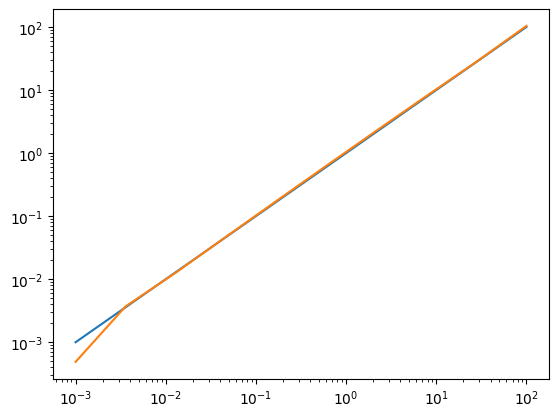

In [16]:
from torch import linspace, logspace
v = logspace(-3,2,10)
n_mantissa = 3
rs = []
shots = int(20)
for shot in range(shots):
    vals = []
    for n in v:
        vals.append(undo_int8_fp8(round_to_fp8_represented_as_int8(n, n_mantissa), n_mantissa, target_dt=torch.float))
    rs.append(torch.tensor(vals))
import matplotlib.pyplot as plt
plt.plot(v,v)
plt.xscale('log')
plt.yscale('log')
plt.plot(v, torch.mean(torch.stack(rs), axis=0))